Shape of X: (4728, 42)
Shape of y: (4728,)
First 5 rows of X:
    upstream_size  downstream_size  paralagous_count  phyletic_retention  \
0              2                0                 1                   2   
1              2                0                 1                   2   
2              2                0                 1                   4   
3              2                1                 2                   4   
4              2                0                 0                   3   

   promoter_count(Harbison_et_al)  DIP_degree  PI  CAI  Codon_bias  ARG  ...  \
0                               0           0   1    0           0    1  ...   
1                               1           0   0    0           0    1  ...   
2                               1           0   0    1           1    0  ...   
3                               0           1   0    1           1    1  ...   
4                               0           1   0    1           1    0  ...   

   mi

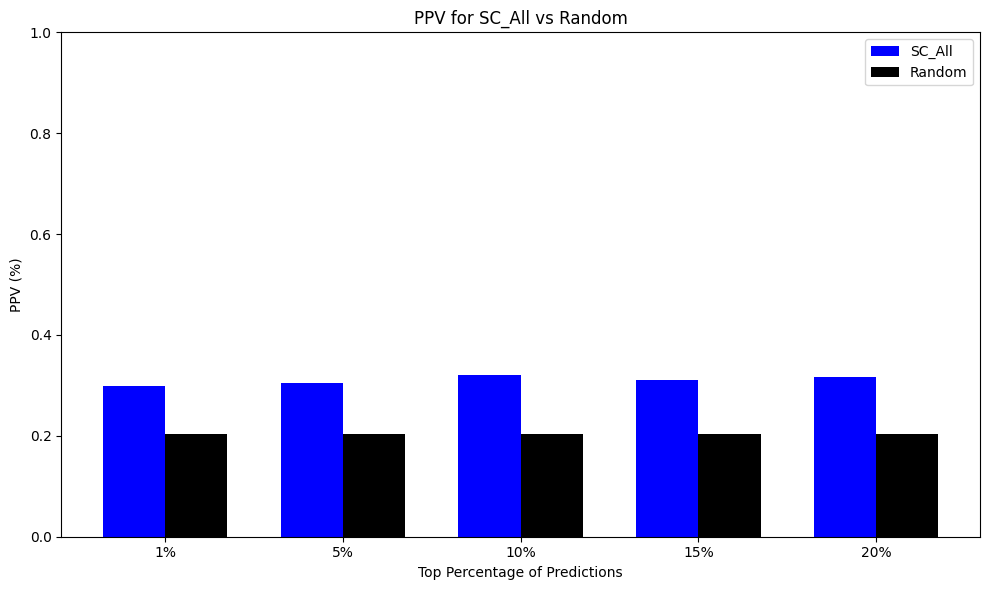

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Function to calculate PPV at top percentiles
def calculate_top_percentile_ppv(probabilities, true_labels, percentiles):
    sorted_indices = np.argsort(probabilities)[::-1]
    sorted_labels = true_labels[sorted_indices]
    ppv_percentiles = []

    for p in percentiles:
        n_top = int(len(sorted_labels) * (p / 100))
        if n_top == 0:
            ppv_percentiles.append(0)
        else:
            top_labels = sorted_labels[:n_top]
            ppv = np.sum(top_labels) / len(top_labels)  # Precision = TP / (TP + FP)
            ppv_percentiles.append(ppv)

    return ppv_percentiles

# Load discretized data (provided dataset)
def load_discretized_data():
    file_path = './cerevisiae_data.xls'  # Replace with correct path
    discretized_data = pd.read_excel(file_path, sheet_name='entropy discretized')

    columns_with_symbols = discretized_data.columns[2:]  # Skip 'Essential' and 'orf_id'
    label_encoders = {}

    for column in columns_with_symbols:
        le = LabelEncoder()
        discretized_data[column] = le.fit_transform(discretized_data[column].astype(str))
        label_encoders[column] = le

    return discretized_data.drop(columns=['Essential', 'orf_id']), discretized_data['Essential']

# Load data and ranking
X, y = load_discretized_data()
CMIM_ranking = ['phyletic_retention', 'paralagous_count', 'DIP_degree', 'nucleolus', 
                'nucleus', 'upstream_size', 'spindle pole', 'GLU', 'Codon_bias', 
                'aromaticity_score', 'Gravy_score', 'CAI', 'downstream_size', 
                'vacuole', 'endosome', 'mitochondrion', 'PI', 'cytoplasm',
                'promoter_count(Harbison_et_al)', 'vacuolar membrane', 'MET', 'ASP', 
                'ER to Golgi', 'GLN', 'peroxisome', 'num places loc', 'LYS', 
                'ambiguous', 'cell periphery', 'FOP_score', 'nuclear periphery', 'ARG', 
                'Golgi to ER', 'punctate composite', 'ER', 'lipid particle', 'microtubule', 
                'Golgi', 'bud neck', 'actin', 'bud', 'Golgi to Vacuole']
X_ranked = X[CMIM_ranking]

# Percentiles for PPV
percentiles = [1, 5, 10, 15, 20]
n_iterations = 100  # Use 100 iterations as per the article
optimal_features = None
highest_ppv_1 = 0
gene_probabilities = np.zeros(len(y))

# Debugging check for initial data
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("First 5 rows of X:\n", X.head())
print("Class distribution in y:", np.bincount(y))

# Feature selection and bootstrapping
for i in range(len(CMIM_ranking), 0, -1):
    X_selected = X_ranked.iloc[:, :i]
    ppv_1_scores = []

    for _ in range(n_iterations):
        X_train, X_test, y_train, y_test = train_test_split(
            X_selected, y, test_size=0.5, stratify=y
        )
        nb_classifier = GaussianNB()
        nb_classifier.fit(X_train, y_train)
        y_prob = nb_classifier.predict_proba(X_test)[:, 1]

        ppv_top = calculate_top_percentile_ppv(y_prob, y_test.to_numpy(), percentiles)
        ppv_1_scores.append(ppv_top[0])

        # Update global probabilities
        gene_indices = y_test.index
        gene_probabilities[gene_indices] += y_prob

    mean_ppv_1 = np.mean(ppv_1_scores)
    print(f"Features: {i}, Mean PPV (1%): {mean_ppv_1}")

    if mean_ppv_1 > highest_ppv_1:
        highest_ppv_1 = mean_ppv_1
        optimal_features = i

gene_probabilities /= n_iterations
print("Highest PPV (1%):", highest_ppv_1)
print("Optimal number of features:", optimal_features)

# Evaluate final probabilities with optimal features
gene_probabilities_final = np.zeros(len(y))
X_optimal = X_ranked.iloc[:, :optimal_features]

for _ in range(n_iterations):
    X_train, X_test, y_train, y_test = train_test_split(
        X_optimal, y, test_size=0.5, stratify=y
    )
    nb_classifier = GaussianNB()
    nb_classifier.fit(X_train, y_train)
    y_prob = nb_classifier.predict_proba(X_test)[:, 1]

    gene_indices = y_test.index
    gene_probabilities_final[gene_indices] += y_prob

gene_probabilities_final /= n_iterations
final_ppv = calculate_top_percentile_ppv(gene_probabilities_final, y.to_numpy(), percentiles)
print("Final PPV Percentiles:", final_ppv)

# Debug aggregated probabilities
print("Aggregated probabilities (first 10):", gene_probabilities_final[:10])

# Plotting final results
fig, ax = plt.subplots(figsize=(10, 6))
sc_all_ppv = final_ppv
random_ppv = [np.mean(y)] * len(percentiles)  # Random baseline

width = 0.35
labels = [f'{p}%' for p in percentiles]
ax.bar(np.arange(len(percentiles)) - width/2, sc_all_ppv, width, label='SC_All', color='blue')
ax.bar(np.arange(len(percentiles)) + width/2, random_ppv, width, label='Random', color='black')

ax.set_xlabel('Top Percentage of Predictions')
ax.set_ylabel('PPV (%)')
ax.set_title('PPV for SC_All vs Random')
ax.set_xticks(np.arange(len(percentiles)))
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.show()
